In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# 将工作环境调整至/data/planogram_segmented下, 获得水平分割完成的图像
path1 = os.path.abspath('..')
path2 = path1.replace('\\', '/')
os.chdir(path2 + '/data/planogram_segmented/')

## 读取IMG_0114.jpg水平分割后的图像

In [3]:
img_1 = cv2.imread('IMG_0114_1.jpg', 1)
img_2 = cv2.imread('IMG_0114_2.jpg', 1)

In [4]:
def gray_image_show(img):
    plt.figure(figsize=(12, 14))
    plt.imshow(img, cmap='gray', interpolation='bicubic')
    plt.xticks([]), plt.yticks([])
    plt.show()

def color_image_show(img):
    plt.figure(figsize=(12, 14))
    image_show = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(image_show, cmap='gray', interpolation='bicubic')
    plt.xticks([]), plt.yticks([])
    plt.show()

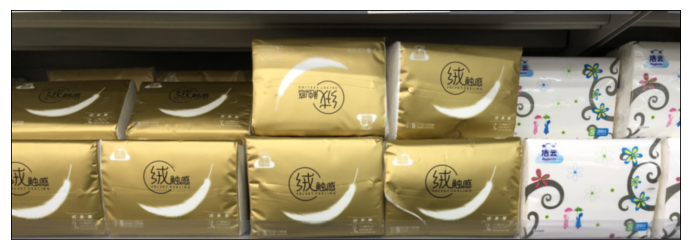

In [5]:
color_image_show(img_1)

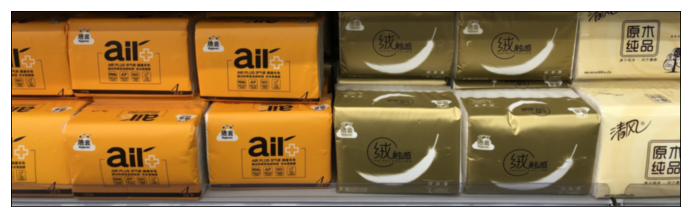

In [6]:
color_image_show(img_2)

## 尝试应用之前对图像水平分割的原理对图像进行垂直分割

In [7]:
gray_img = cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)
blur_img = cv2.GaussianBlur(gray_img, (5, 5), 2)
canny_img = cv2.Canny(blur_img, 50, 200)

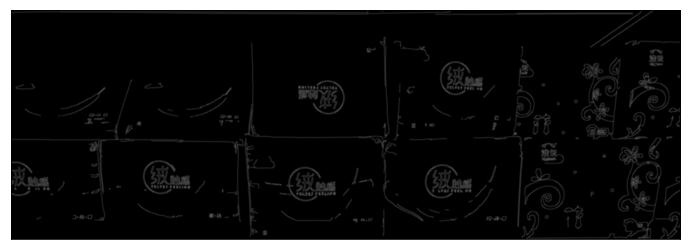

In [8]:
gray_image_show(canny_img)

In [9]:
img_1_transpose = np.swapaxes(canny_img, 0, 1)
img_1_array = []
for line in img_1_transpose:
    img_1_array.append(line.sum())

img_1_array = np.asarray(img_1_array)
img_1_df = pd.DataFrame(img_1_array, columns=['gray_sum'])
img_1_df = img_1_df/img_1_array.max()

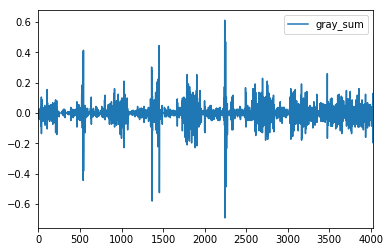

In [10]:
img_1_df.diff().plot()

In [11]:
def show_gray_diff(image, blur_size=3, canny_threshold_1=50, canny_threshold_2=200):
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur_img = cv2.GaussianBlur(image, (blur_size, blur_size), 2)
    canny_img = cv2.Canny(image, canny_threshold_1, canny_threshold_2)
    image_transpose = np.swapaxes(image, 0, 1)
    image_array = []
    for line in image_transpose:
        image_array.append(line.sum())
    
    image_array = np.asarray(image_array)
    image_df = pd.DataFrame(image_array, columns=['gray_sum'])
    image_df = image_df/image_array.max()
    image_df = image_df.diff()
    image_df['gray_sum'] = image_df['gray_sum'].map(np.fabs)
    image_df.plot()
    return image_df

## 显示图像灰度导数（绝对值）直方图

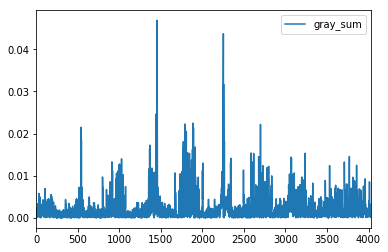

In [12]:
df1 = show_gray_diff(img_1, canny_threshold_1=100)

### 使用灰度变化对图像进行垂直分割的效果不佳

In [13]:
gray_img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2GRAY)

## 对图像应用line segment detector直线检测器

In [14]:
lsd = cv2.createLineSegmentDetector(0)
blur_img_2 = cv2.GaussianBlur(gray_img_2, (5, 5), 2)
lines = lsd.detect(blur_img_2)[0]

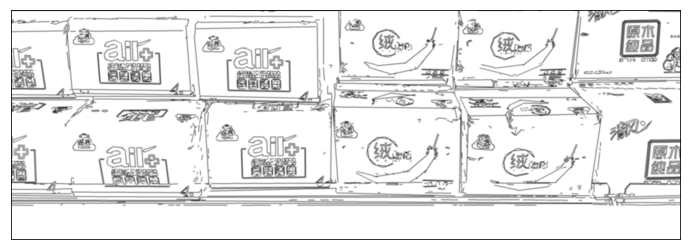

In [15]:
img_blank = np.zeros(gray_img.shape)
img_blank[:, :] = 255
for line in lines:
    x0 = int(round(line[0][0]))
    y0 = int(round(line[0][1]))
    x1 = int(round(line[0][2]))
    y1 = int(round(line[0][3]))
    cv2.line(img_blank, (x0, y0), (x1, y1), 0, 2, cv2.LINE_AA)

gray_image_show(img_blank)

转换lsd算法检测图像得到的直线结果的数据结构

In [16]:
lines_sp = []
for line in lines:
    x0 = int(round(line[0][0]))
    y0 = int(round(line[0][1]))
    x1 = int(round(line[0][2]))
    y1 = int(round(line[0][3]))
    lines_sp.append([(x0, y0), (x1, y1)])

## 筛选直线中的垂直和水平直线

In [17]:
def line_filter_by_angle(lines, angle_precision=10):
    line_list = []
    for line in lines:
        x0 = line[0][0]
        y0 = line[0][1]
        x1 = line[1][0]
        y1 = line[1][1]
        if x0 == x1 or y0 == y1:
            line_list.append([(x0, y0), (x1, y1)])
        elif not angle_precision <= np.arctan(np.fabs(x0 - x1) / np.fabs(y0 - y1)) * 180 / np.pi <= (90 - angle_precision):
            line_list.append([(x0, y0), (x1, y1)])
    return line_list

In [18]:
lines_1 = line_filter_by_angle(lines_sp, 10)

In [19]:
def line_drawer(lines, image_size):
    mask = np.zeros(image_size)
    mask[:, :] = 255
    for line in lines:
        cv2.line(mask, line[0], line[1], 0, 2, cv2.LINE_AA)
    
    gray_image_show(mask)

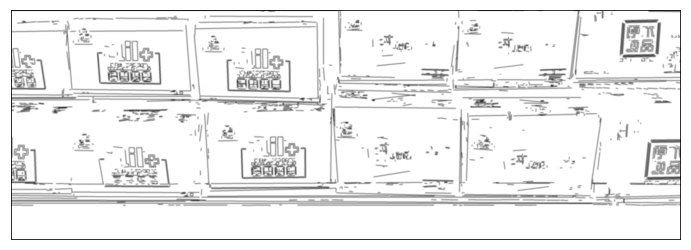

In [20]:
line_drawer(lines_1, gray_img.shape)

## 筛选直线中的垂直和水平直线，同时剔除较短的、过于细节和过长的直线

In [21]:
def line_filter_by_angle_distance(lines, distance_min, distance_max, angle_precision=10):
    line_list = []
    for line in lines:
        x0 = line[0][0]
        y0 = line[0][1]
        x1 = line[1][0]
        y1 = line[1][1]
        if distance_min <= np.sqrt((x0 - x1) ** 2 + (y0 - y1) ** 2) <= distance_max:
            if x0 == x1 or y0 == y1:
                line_list.append([(x0, y0), (x1, y1)])
            elif not angle_precision <= np.arctan(np.fabs(y0 - y1) / np.fabs(x0 - x1)) * 180 / np.pi <= (90 - angle_precision):
                line_list.append([(x0, y0), (x1, y1)])
    return line_list

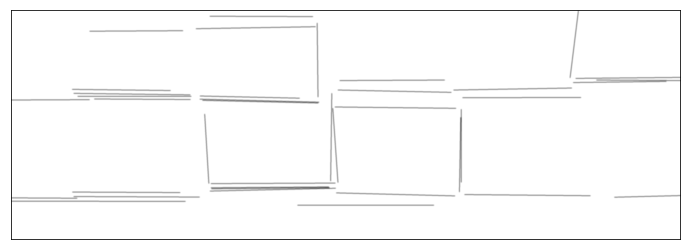

In [22]:
lines_2 = line_filter_by_angle_distance(lines_sp, gray_img.shape[0]/3.5, gray_img.shape[0]/1.3)
line_drawer(lines_2, gray_img.shape)

In [23]:
len(lines_2)

38

## 定义函数提取垂直直线和水平直线

In [24]:
def sort_lines(lines):
    line_list_hor = []
    line_list_ver = []
    for line in lines:
        x0 = line[0][0]
        y0 = line[0][1]
        x1 = line[1][0]
        y1 = line[1][1]
        if x0 == x1:
            line_list_ver.append([(x0, y0), (x1, y1)])
        elif y0 == y1:
            line_list_hor.append([(x0, y0), (x1, y1)])
        elif np.arctan(np.fabs(y0 - y1) / np.fabs(x0 - x1)) * 180 / np.pi < 10:
            line_list_hor.append([(x0, y0), (x1, y1)])
        elif np.arctan(np.fabs(y0 - y1) / np.fabs(x0 - x1)) * 180 / np.pi > 80:
            line_list_ver.append([(x0, y0), (x1, y1)])
    
    return line_list_hor, line_list_ver        

In [25]:
lines_2_hor, lines_2_ver = sort_lines(lines_2)

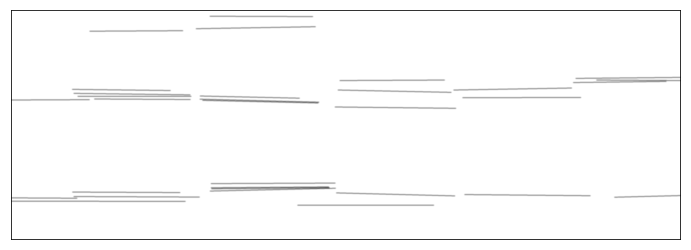

In [26]:
line_drawer(lines_2_hor, gray_img.shape)

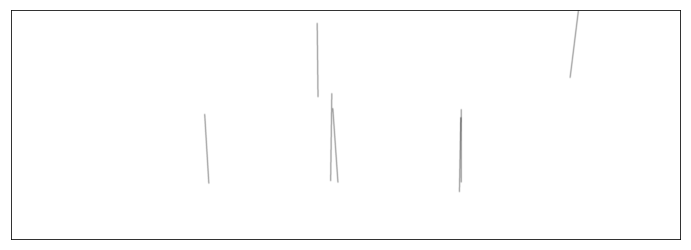

In [27]:
line_drawer(lines_2_ver, gray_img.shape)

## 分别对垂直线段和水平线段长度做统计描述

In [28]:
length_hor = []
length_ver = []
for line in lines_2_hor:
    x0 = line[0][0]
    y0 = line[0][1]
    x1 = line[1][0]
    y1 = line[1][1]
    length_hor.append(np.sqrt((x0 - x1) ** 2 + (y0 - y1) ** 2))

for line in lines_2_ver:
    x0 = line[0][0]
    y0 = line[0][1]
    x1 = line[1][0]
    y1 = line[1][1]
    length_ver.append(np.sqrt((x0 - x1) ** 2 + (y0 - y1) ** 2))

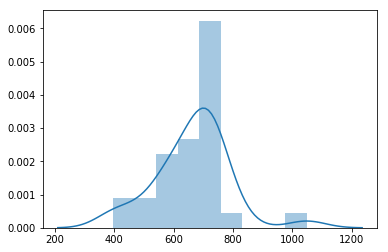

In [29]:
sns.distplot(length_hor)

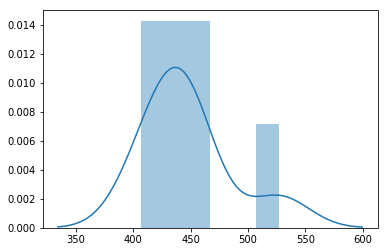

In [30]:
sns.distplot(length_ver)

In [31]:
hor_array = np.asarray(length_hor)
ver_array = np.asarray(length_ver)

In [32]:
hor_array.sort()

## 使用垂直线段和水平线段的平均值作为sliding window的尺寸
**——（尺寸需要适当扩大）**

In [33]:
round(hor_array.mean()), round(ver_array.mean())

(663.0, 447.0)

## sliding window在图像中的效果
**——（长宽各增加了50）**

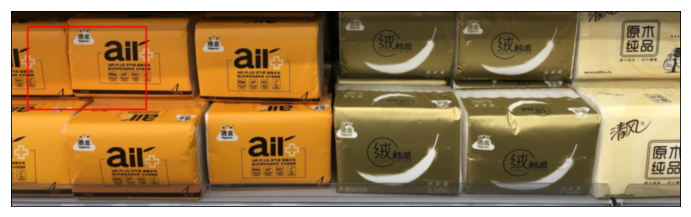

In [34]:
cv2.rectangle(img_2, (100, 100), (813, 597), (0, 0, 255), 7)
color_image_show(img_2)